In [63]:
import time
import numpy as np 
import pandas as pd 
from IPython.display import clear_output
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d   ## smoother
from tqdm.notebook import tqdm


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
from sklearn.preprocessing import MinMaxScaler
        
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold

plt.rcParams['figure.figsize'] = 15, 7



def seed_everything(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)


/kaggle/input/lish-moa/train_features.csv
/kaggle/input/lish-moa/test_features.csv
/kaggle/input/lish-moa/train_targets_nonscored.csv
/kaggle/input/lish-moa/sample_submission.csv
/kaggle/input/lish-moa/train_targets_scored.csv


In [64]:
if torch.cuda.is_available():
    device='cuda'
else:
    device='cpu'
device

'cuda'

In [65]:
train_features = pd.read_csv('../input/lish-moa/train_features.csv')
train_targets_scored = pd.read_csv('../input/lish-moa/train_targets_scored.csv')

test_features = pd.read_csv('../input/lish-moa/test_features.csv')
submission = pd.read_csv('../input/lish-moa/sample_submission.csv')

In [66]:
train_features.cp_time.unique(), train_features.cp_type.unique(),  train_features.cp_dose.unique()

(array([24, 72, 48]),
 array(['trt_cp', 'ctl_vehicle'], dtype=object),
 array(['D1', 'D2'], dtype=object))

In [67]:
train_features.shape, test_features.shape

((23814, 876), (3982, 876))

In [68]:
ignore_columns = ['sig_id', "cp_type"]

train_columns = [x for x in train_features.columns if x not in ignore_columns]

train = train_features[train_columns]
test = test_features[train_columns]
target = train_targets_scored.iloc[:,1:].values

In [69]:
train.shape, test.shape, target.shape

((23814, 874), (3982, 874), (23814, 206))

In [70]:
transform = ColumnTransformer([
                            ('o',OneHotEncoder(),[0,1]),
                            ('s',Normalizer(),list(range(3,train.shape[1])))
                        ])


train = transform.fit_transform(train)
test = transform.transform(test)
test.shape

(3982, 876)

In [71]:
class TrainDataset(Dataset):
    def __init__(self, train,targets, noise ):
        
        self.features  = train
        self.targets = targets
        self.noise = noise
        
    def sizes(self):
        print("features size = ", self.features.shape[1])
        print("targets size = ", self.targets.shape[1])

        
    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        feature = torch.tensor(self.features[idx]).float() 
        
#         if self.noise == True:
# #             print("noisy boi")
#             feature  = feature + torch.randn_like(feature)/150
            
        target = torch.tensor(self.targets[idx]).float()
        
        return feature,target

In [72]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
        
def show_lr(learning_rates):
    plt.plot(learning_rates, label = "learning rate")
    plt.ylabel("Learning rate", fontsize = 15)
    plt.grid(True)
    plt.legend()
    plt.show()

def train_step(x, y, model, optimizer, criterion):
    optimizer.zero_grad()
    pred = model(x.to(device))
    y = y.float()
    loss = criterion(pred,y.to(device))
    loss.backward()
    optimizer.step()
    return loss.item()

In [73]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        
        

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(876)
        self.dropout1 = nn.Dropout(0.2)
        self.dense1 = nn.utils.weight_norm(nn.Linear(876, 1048))
        
        self.batch_norm2 = nn.BatchNorm1d(1048)
        self.dropout2 = nn.Dropout(0.5)
        self.dense2 = nn.utils.weight_norm(nn.Linear(1048, 2096))
        
        self.batch_norm3 = nn.BatchNorm1d(2096)
        self.dropout3 = nn.Dropout(0.5)
        self.dense3 = nn.utils.weight_norm(nn.Linear(2096, 2096))
        
        self.batch_norm4 = nn.BatchNorm1d(2096)
        self.dropout4 = nn.Dropout(0.5)
        self.dense4 = nn.utils.weight_norm(nn.Linear(2096, 1048))
        
        self.batch_norm5 = nn.BatchNorm1d(1048)
        #self.dropout5 = nn.Dropout(0.5)
        self.dense5 = nn.utils.weight_norm(nn.Linear(1048, 206))
    
    def forward(self, x):
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = F.leaky_relu(self.dense1(x))
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.leaky_relu(self.dense2(x))
        
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = F.leaky_relu(self.dense3(x))
        
        x = self.batch_norm4(x)
        x = self.dropout4(x)
        x = F.leaky_relu(self.dense4(x))
        
        x = self.batch_norm5(x)
        #x = self.dropout5(x)
        x = (self.dense5(x))
        
        return x
    
    
    
model = Model()

In [74]:

def train_one_fold(model,num_epochs , train_loader,val_loader, optimizer, scheduler, criterion, fold_number = 1, show_plots = False, train = True, validate = True):
    
    losses = []
    val_losses = []
    learning_rates = []    
    best_loss = 1000000

    for epoch in range(num_epochs):

            
        if train == True:
            model.train()
            losses_temp = []
            for batch in train_loader:
                (x_batch, y_batch) = batch
                loss = train_step(x_batch.to(device), y_batch.to(device), model, optimizer, criterion)
                losses_temp.append(loss)
            losses.append(torch.mean(torch.tensor(losses_temp)))
            scheduler.step(1.)   ## lr decay caller 
            learning_rates.append(get_lr(optimizer))
            

        if validate == True:
            with torch.no_grad():
                model.eval()
                val_losses_temp = []
                for x_val, y_val in val_loader:
                    yhat =model(x_val.to(device))  # pred 
                    val_loss = criterion(yhat.to(device), y_val.to(device))
                    val_losses_temp.append(val_loss.item())  ## metrics 
                val_losses.append(torch.mean(torch.tensor(val_losses_temp)).item())  ## metrics 

        
        if train == True:
            print ("epoch ", epoch+1, " out of ", num_epochs, end = "      >" )

            if val_losses[-1] <= best_loss:

                print(CGREEN, "Val loss decreased from:", best_loss, " to ", val_losses[-1], CEND, end = "   >")
                best_loss = val_losses[-1]

                name = "./model_" + str(fold_number)+".pth"

                print("saving model as: ", name)

                torch.save(model.state_dict(), name)

            else: 
                print("showing no improvements, best loss yet:", best_loss)

        if show_plots == True:

            show_lr(learning_rates)
            plt.plot(val_losses, label = "val")
            plt.axhline(min(val_losses), linestyle = "--", c = "r")
            plt.legend()
            plt.grid()
            plt.show()


            plt.plot(val_losses[4:], label = "val after main drop", c = "g")
            plt.axhline(min(val_losses), linestyle = "--", c = "r")
            plt.legend()
            plt.grid()
            plt.show()


            plt.plot(losses, label = "train")
            plt.legend()
            plt.grid()
            plt.show()
        
    return losses, val_losses

In [ ]:
## building folds 

CGREEN  = '\33[32m'
CBLUE =  '\033[34m'
CRED = '\033[1;31m'
CEND  = '\33[0m'


NFOLDS =10
num_epochs = 35


kfold = KFold(NFOLDS,shuffle=True,random_state=42)
fold_train_losses = list()
fold_valid_losses = list()


for k , (train_idx,valid_idx) in enumerate(kfold.split(train)):

    x_train,x_valid,y_train,y_valid = train[train_idx,:],train[valid_idx,:],target[train_idx,:],target[valid_idx,:]

    input_size = x_train.shape[1]
    output_size = target.shape[1]
    
    
    train_dataset = TrainDataset(x_train, y_train, noise = False)
    valid_dataset = TrainDataset(x_valid, y_valid, noise = False)
    
    train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, num_workers = 8)

    val_loader = DataLoader(dataset=valid_dataset, batch_size=256, shuffle = True, num_workers = 8)
    
    model = Model()
    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=0.4e-3)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                     mode='min', 
                                                     factor=0.5, 
                                                     patience=5, 
                                                     eps=1e-5, 
                                                     verbose=True)
    criterion = nn.BCEWithLogitsLoss()
    print(CRED ,"fold ", str(k+1), CEND)

    train_one_fold(model, num_epochs , train_loader,val_loader, optimizer, scheduler, criterion, fold_number = k+1)
    
print(CBLUE, "Training complete", CEND)

 fold  1 
epoch  1  out of  35      > Val loss decreased from: 1000000  to  0.060287754982709885    >saving model as:  ./model_1.pth
epoch  2  out of  35      > Val loss decreased from: 0.060287754982709885  to  0.028751742094755173    >saving model as:  ./model_1.pth


In [77]:
all_models = [Model() for i in range (NFOLDS)]

for i in range (len(all_models)):
    
    name = "./model_" + str(i + 1) + ".pth"
    all_models[i].load_state_dict(torch.load(name))
    all_models[i].to(device)
    print("Loaded: ", name)



Loaded:  ./model_1.pth
Loaded:  ./model_2.pth
Loaded:  ./model_3.pth
Loaded:  ./model_4.pth
Loaded:  ./model_5.pth
Loaded:  ./model_6.pth
Loaded:  ./model_7.pth
Loaded:  ./model_8.pth
Loaded:  ./model_9.pth
Loaded:  ./model_10.pth


In [78]:
all_val_losses = []
for i in range(NFOLDS):
    losses, val_losses = train_one_fold(all_models[i],5 , train_loader,val_loader, optimizer, scheduler, criterion, fold_number = 0, train = False, validate = True)
    all_val_losses.append(np.mean(np.array(val_losses)))
all_val_losses = np.array(all_val_losses)

In [79]:
class model_jury(object):   ## only works for dataloaders for batch size 1 
    def __init__(self, all_models):
        self.all_models = all_models
        
        
        
    def predict(self, x, plot = False, sigmoid = False):
        
        with torch.no_grad():
            
            if sigmoid == False:
                preds = [self.all_models[i](x.to(device)).view(-1).cpu().tolist() for i in range(len(self.all_models))]
            else:
                preds = [self.all_models[i](x.to(device)).view(-1).cpu().sigmoid().tolist() for i in range(len(self.all_models))]

        
        if plot == True:
            for pred in preds:
                plt.plot(pred)
            plt.show()
            
        preds = np.array(preds)
        mean = np.mean(preds, axis = 0)
        return mean.flatten()

In [80]:
jury = model_jury(all_models)

In [81]:
test_dataset = TrainDataset(test, target, noise = False)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False, num_workers = 8)
val_loader_test_jury = DataLoader(dataset= valid_dataset, batch_size=1, shuffle=False, num_workers = 8)

In [82]:
with torch.no_grad():
    benchmark_losses = []
    criterion = nn.BCEWithLogitsLoss()
    for batch in tqdm(val_loader_test_jury):
        x, y = batch
        pred = jury.predict(x, plot = False, sigmoid = False)
        pred = torch.tensor(pred).view(1,-1)

        benchmark_losses.append(criterion(pred, y))

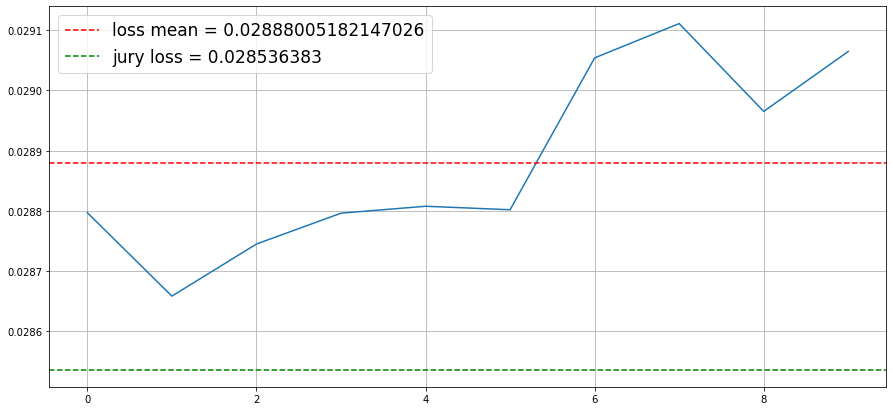

In [83]:
plt.plot(all_val_losses)
plt.axhline(y = all_val_losses.mean(), label = "loss mean = " + str(all_val_losses.mean()), c = "r", linestyle = "--")
plt.axhline(y = np.array(benchmark_losses).mean(), label = "jury loss = " + str(np.array(benchmark_losses).mean()), c = "g", linestyle = "--")
plt.legend(fontsize = 17)
plt.grid()
plt.show()

In [84]:
list_of_preds = []
for batch in tqdm(test_loader):
    x, y = batch
    foo = jury.predict(x, plot = False, sigmoid = True)
    list_of_preds.append(foo)


In [85]:
submission = pd.read_csv('../input/lish-moa/sample_submission.csv')
sub_cp = submission
sub_cp.to_csv('./submission_cp.csv', index=None, header=True)

In [86]:
import csv 
a = list_of_preds  
with open('./submission_cp.csv', "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(a)

In [87]:
final_sub = pd.read_csv('./submission_cp.csv', header = None)
final_sub.head()

,0,1,2,3,4,5,6,7,8,9,...,196,197,198,199,200,201,202,203,204,205
0,0.015346,0.015575,0.016059,0.017943,0.022307,0.016262,0.016822,0.017622,0.014816,0.020164,...,0.014918,0.014924,0.015818,0.017054,0.017316,0.015078,0.019358,0.015466,0.015455,0.015681
1,0.015174,0.015406,0.016083,0.017687,0.021101,0.016199,0.016646,0.017517,0.014936,0.019870,...,0.015043,0.015259,0.015861,0.021727,0.017607,0.015170,0.020022,0.015497,0.015812,0.015629
2,0.015481,0.015297,0.013934,0.016388,0.016298,0.017206,0.013807,0.014279,0.016342,0.016291,...,0.015695,0.015392,0.014699,0.013772,0.013426,0.015080,0.013016,0.015906,0.015182,0.015390
3,0.015285,0.015535,0.016079,0.017836,0.022169,0.016287,0.016783,0.017601,0.014879,0.020107,...,0.014964,0.015010,0.015835,0.017930,0.017407,0.015119,0.019511,0.015481,0.015575,0.015674
4,0.016661,0.015080,0.012995,0.016944,0.013496,0.016717,0.012096,0.012085,0.016803,0.015503,...,0.015622,0.014692,0.013886,0.007089,0.011217,0.014887,0.009795,0.015979,0.014384,0.014738


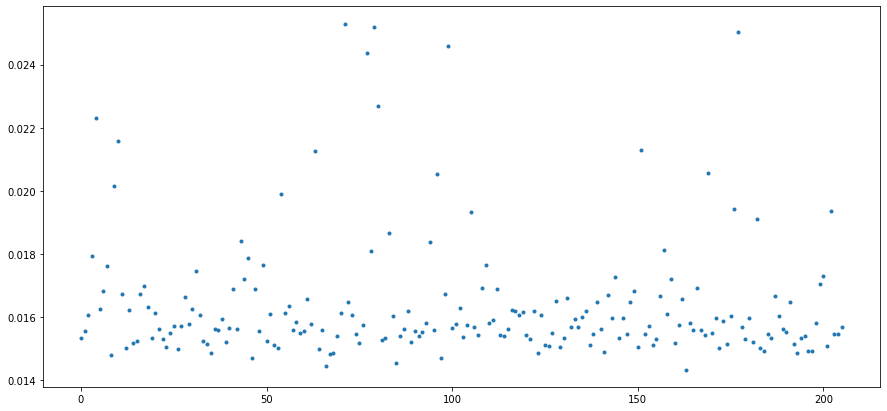

In [88]:
plt.plot(final_sub.values[0], ".")

In [89]:
final_sub = pd.read_csv('./submission_cp.csv', header = None)
final_sub.head()

,0,1,2,3,4,5,6,7,8,9,...,196,197,198,199,200,201,202,203,204,205
0,0.015346,0.015575,0.016059,0.017943,0.022307,0.016262,0.016822,0.017622,0.014816,0.020164,...,0.014918,0.014924,0.015818,0.017054,0.017316,0.015078,0.019358,0.015466,0.015455,0.015681
1,0.015174,0.015406,0.016083,0.017687,0.021101,0.016199,0.016646,0.017517,0.014936,0.019870,...,0.015043,0.015259,0.015861,0.021727,0.017607,0.015170,0.020022,0.015497,0.015812,0.015629
2,0.015481,0.015297,0.013934,0.016388,0.016298,0.017206,0.013807,0.014279,0.016342,0.016291,...,0.015695,0.015392,0.014699,0.013772,0.013426,0.015080,0.013016,0.015906,0.015182,0.015390
3,0.015285,0.015535,0.016079,0.017836,0.022169,0.016287,0.016783,0.017601,0.014879,0.020107,...,0.014964,0.015010,0.015835,0.017930,0.017407,0.015119,0.019511,0.015481,0.015575,0.015674
4,0.016661,0.015080,0.012995,0.016944,0.013496,0.016717,0.012096,0.012085,0.016803,0.015503,...,0.015622,0.014692,0.013886,0.007089,0.011217,0.014887,0.009795,0.015979,0.014384,0.014738


In [90]:
final_sub.columns = submission.columns[1:]
final_sub["sig_id"] = submission["sig_id"]


In [91]:
good_cols = np.roll(final_sub.columns.values, 1)
final_sub = final_sub[good_cols]

In [92]:
final_sub.to_csv("./submission.csv", index=False)
final_sub

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.015346,0.015575,0.016059,0.017943,0.022307,0.016262,0.016822,0.017622,0.014816,...,0.014918,0.014924,0.015818,0.017054,0.017316,0.015078,0.019358,0.015466,0.015455,0.015681
1,id_001897cda,0.015174,0.015406,0.016083,0.017687,0.021101,0.016199,0.016646,0.017517,0.014936,...,0.015043,0.015259,0.015861,0.021727,0.017607,0.015170,0.020022,0.015497,0.015812,0.015629
2,id_002429b5b,0.015481,0.015297,0.013934,0.016388,0.016298,0.017206,0.013807,0.014279,0.016342,...,0.015695,0.015392,0.014699,0.013772,0.013426,0.015080,0.013016,0.015906,0.015182,0.015390
3,id_00276f245,0.015285,0.015535,0.016079,0.017836,0.022169,0.016287,0.016783,0.017601,0.014879,...,0.014964,0.015010,0.015835,0.017930,0.017407,0.015119,0.019511,0.015481,0.015575,0.015674
4,id_0027f1083,0.016661,0.015080,0.012995,0.016944,0.013496,0.016717,0.012096,0.012085,0.016803,...,0.015622,0.014692,0.013886,0.007089,0.011217,0.014887,0.009795,0.015979,0.014384,0.014738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3977,id_ff7004b87,0.015062,0.015011,0.015901,0.015866,0.015721,0.015568,0.016395,0.016213,0.015099,...,0.015387,0.016582,0.015894,0.046211,0.017419,0.015448,0.020148,0.015821,0.016138,0.015399
3978,id_ff925dd0d,0.016146,0.015060,0.013899,0.017438,0.015435,0.015813,0.013773,0.013507,0.015580,...,0.015456,0.014947,0.014345,0.012078,0.012965,0.015009,0.012386,0.015879,0.015093,0.014961
3979,id_ffb710450,0.015288,0.015264,0.013432,0.015797,0.016308,0.017171,0.014080,0.013750,0.015758,...,0.015713,0.015093,0.015103,0.012551,0.013615,0.015165,0.012934,0.016270,0.015714,0.015196
3980,id_ffbb869f2,0.015514,0.015655,0.015977,0.018197,0.023823,0.016217,0.017054,0.017655,0.014686,...,0.014731,0.014561,0.015743,0.013457,0.017014,0.015000,0.018670,0.015521,0.015092,0.015699
